In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## Simple Convolutional Autoencoder (CAE) for 112x112 Images

### Test 1

In [4]:
# info: https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/

# Define the CAE architecture
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        """
        encoder architecture explained:
        - input: 3x64x64
        - output: 8x8x8

        1. Conv2d: 3 input channels, 16 output channels, kernel size 3, stride 1, padding 1
        2. ReLU activation function
        3. MaxPool2d: kernel size 2, stride 2
        4. Conv2d: 16 input channels, 8 output channels, kernel size 3, stride 1, padding 1
        5. ReLU activation function
        6. MaxPool2d: kernel size 2, stride 2
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        decoder architecture explained:
        - input: 8x8x8
        - output: 3x64x64
        1. ConvTranspose2d: 8 input channels, 16 output channels, kernel size 3, stride 2, padding 1, output padding 1
        2. ReLU activation function
        3. ConvTranspose2d: 16 input channels, 3 output channels, kernel size 3, stride 2, padding 1, output padding 1
        4. Sigmoid activation function
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re
 
 
# Initialize the CAE
model = CAE()
 
# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
 
# Load dataset
train_dataset = datasets.Flowers102(root='flowers', 
                                    split='train', 
                                    transform=transform, 
                                    download=True)
test_dataset = datasets.Flowers102(root='flowers', 
                                   split='test', 
                                   transform=transform)
# Define the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=128)
 
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
 
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# Train the CAE
num_epochs = 50
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
torch.save(model.state_dict(), 'CAE_0.pth')

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers/flowers-102/102flowers.tgz to flowers/flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

cpu


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch [1/50], Loss: 0.0941
Epoch [6/50], Loss: 0.0673
Epoch [11/50], Loss: 0.0353
Epoch [16/50], Loss: 0.0275
Epoch [21/50], Loss: 0.0209
Epoch [26/50], Loss: 0.0163
Epoch [31/50], Loss: 0.0137
Epoch [36/50], Loss: 0.0140
Epoch [41/50], Loss: 0.0131
Epoch [46/50], Loss: 0.0120


<Figure size 1600x1200 with 0 Axes>

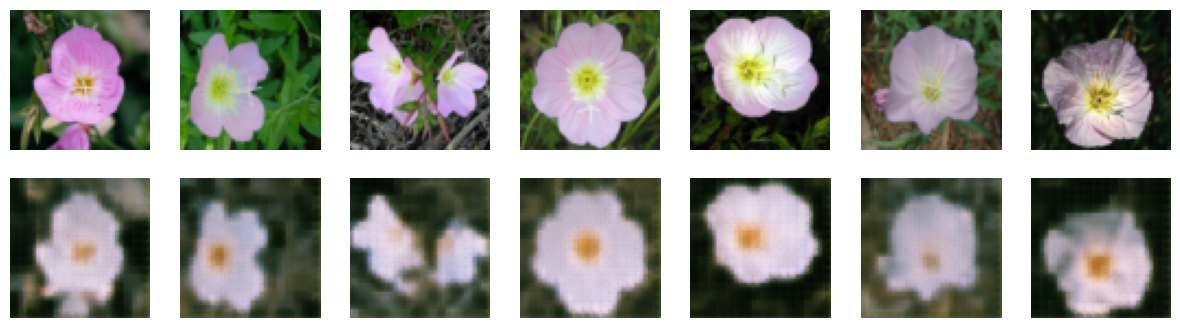

In [5]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
         
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

In [7]:
# print size of original images, the encoded images and the decoded images
print(data[0].size())
print(recon[0].size())
print(output[0].size())

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
